In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

import os
import zipfile
import urllib.request
import random
from IPython import display

In [90]:
# set a random seed
np.random.seed(51)

# parameters for building the model and training
BATCH_SIZE=128
LATENT_DIM=64
IMAGE_SIZE=128

In [91]:
# Data Preparation Utilities

def get_dataset_slice_paths(image_dir):
  #returns a list of paths to the image files
  image_file_list = os.listdir(image_dir)
  image_paths = [os.path.join(image_dir, fname) for fname in image_file_list]

  return image_paths


def map_image(image_filename):
  #preprocesses the images
  img_raw = tf.io.read_file(image_filename)
  image = tf.image.decode_png(img_raw)

  image = tf.cast(image, dtype=tf.float32)
  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
  image = image / 255.0
  image = tf.reshape(image, shape=(IMAGE_SIZE, IMAGE_SIZE, 3,))

  return image

In [5]:
!unzip -o -q ./simpson.zip

In [92]:
# get the list containing the image paths
paths = get_dataset_slice_paths("./cropped")

# shuffle the paths
random.shuffle(paths)

# split the paths list into to training (80%) and validation sets(20%).
paths_len = len(paths)
train_paths_len = int(paths_len * 0.8)

train_paths = paths[:train_paths_len]
val_paths = paths[train_paths_len:]

# load the training image paths into tensors, create batches and shuffle
training_dataset = tf.data.Dataset.from_tensor_slices((train_paths))
training_dataset = training_dataset.map(map_image)
training_dataset = training_dataset.shuffle(1000).batch(BATCH_SIZE)

# load the validation image paths into tensors and create batches
validation_dataset = tf.data.Dataset.from_tensor_slices((val_paths))
validation_dataset = validation_dataset.map(map_image)
validation_dataset = validation_dataset.batch(BATCH_SIZE)


print(f'number of batches in the training set: {len(training_dataset)}')
print(f'number of batches in the validation set: {len(validation_dataset)}')

number of batches in the training set: 62
number of batches in the validation set: 16


In [95]:
def display_faces(dataset, size=9):
  #Takes a sample from a dataset batch and plots it in a grid
  dataset = dataset.unbatch().take(size)
  n_cols = 3
  n_rows = size//n_cols + 1
  plt.figure(figsize=(5, 5))
  i = 0
  for image in dataset:
    i += 1
    disp_img = np.reshape(image, (128,128,3))
    plt.subplot(n_rows, n_cols, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(disp_img)


def display_one_row(disp_images, offset, shape=(28, 28)):
  #Displays a row of images
  for idx, image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    image = np.reshape(image, shape)
    plt.imshow(image)


def display_results(disp_input_images, disp_predicted):
  #Displays input and predicted images
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(IMAGE_SIZE,IMAGE_SIZE,3))
  display_one_row(disp_predicted, 20, shape=(IMAGE_SIZE,IMAGE_SIZE,3))


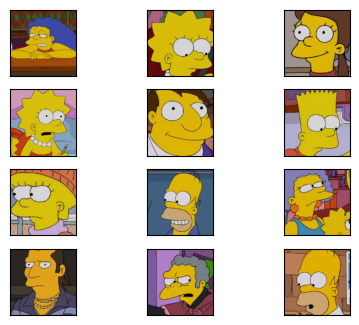

In [96]:
display_faces(validation_dataset, size=12)

In [97]:
class Sampling(tf.keras.layers.Layer):
  def call(self, inputs):
   ''' Generates a random sample and combines with the encoder output

    Args:
      inputs -- output tensor from the encoder

    Returns:
      `inputs` tensors combined with a random sample
    '''
    mu, sigma = inputs
    batch = tf.shape(mu)[0]
    dim = tf.shape(mu)[1]
    epsilon = tf.keras.backend.random_normal(shape = (batch, dim))
    z = mu + tf.exp(0.5 * sigma) * epsilon
    
    return  z

In [98]:
def encoder_layers(inputs, latent_dim):
  """Defines the encoder's layers.
  Args:
    inputs -- batch from the dataset
    latent_dim -- dimensionality of the latent space

  Returns:
    mu -- learned mean
    sigma -- learned standard deviation
    batch_3.shape -- shape of the features before flattening
  """

  x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), strides = 2,
                             activation = 'relu', padding = 'same',
                             name = 'enc_conv1')(inputs)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), strides = 2,
                             activation = 'relu', padding = 'same',
                             name = 'enc_conv2')(x)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), strides = 2,
                             activation = 'relu', padding = 'same',
                             name = 'enc_conv3')(x)
  batch_3 = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Flatten(name = 'enc_flatten')(batch_3)

  x = tf.keras.layers.Dense(1024, activation = 'relu', name = 'enc_dense')(x)
  x = tf.keras.layers.BatchNormalization()(x)

  mu = tf.keras.layers.Dense(LATENT_DIM, name = 'latent_mu')(x)
  sigma = tf.keras.layers.Dense(LATENT_DIM, name = 'latent_sigma')(x)
  conv_shape = tf.keras.backend.int_shape(batch_3)

  return mu, sigma, conv_shape

In [99]:
def encoder_model(latent_dim, input_shape):
  """Defines the encoder model with the Sampling layer
  Args:
    latent_dim -- dimensionality of the latent space
    input_shape -- shape of the dataset batch

  Returns:
    model -- the encoder model
    conv_shape -- shape of the features before flattening
  """

  inputs = tf.keras.layers.Input(shape = input_shape)
  mu, sigma, conv_shape = encoder_layers(inputs, latent_dim = LATENT_DIM)
  z = Sampling()((mu, sigma))
  model = tf.keras.Model(inputs, outputs = [mu, sigma, z])
  model.summary()
  return model, conv_shape

In [100]:
def decoder_layers(inputs, conv_shape):
  """Defines the decoder layers.
  Args:
    inputs -- output of the encoder
    conv_shape -- shape of the features before flattening

  Returns:
    tensor containing the decoded output
  """
  units = conv_shape[1] * conv_shape[2] * conv_shape[3]
  x = tf.keras.layers.Dense(units, activation = 'relu', name = 'dec_dense')(inputs)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]),
                              name = 'dec_reshape')(x)

  x = tf.keras.layers.Conv2DTranspose(filters = 128, kernel_size = (3, 3),
                                      strides = 2, activation = 'relu',
                                      padding = 'same', name = 'dec_deconv1')(x)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2DTranspose(filters = 64, kernel_size = (3, 3),
                                      strides = 2, activation = 'relu',
                                      padding = 'same', name = 'dec_deconv2')(x)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2DTranspose(filters = 32, kernel_size = (3, 3),
                                      strides = 2, activation = 'relu',
                                      padding = 'same', name = 'dec_deconv3')(x)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2DTranspose(filters = 3, kernel_size = (3, 3),
                                      strides = 1, activation = 'sigmoid',
                                      padding = 'same', name = 'dec_deconv4')(x)
  return x

In [101]:
def decoder_model(latent_dim, conv_shape):
  """Defines the decoder model.
  Args:
    latent_dim -- dimensionality of the latent space
    conv_shape -- shape of the features before flattening

  Returns:
    model -- the decoder model
  """
  inputs = tf.keras.layers.Input(shape = (latent_dim, ))
  outputs = decoder_layers(inputs, conv_shape)
  model = tf.keras.Model(inputs, outputs)
  model.summary()
  return model

In [102]:
from tensorflow.keras import layers, models
class VAELossLayer(layers.Layer):
    def call(self, inputs):
        x, reconstructed, mu, sigma = inputs
        kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
        total_loss = tf.reduce_mean(kl_loss) * -0.5
        self.add_loss(total_loss)
        return reconstructed

In [103]:
def vae_model(encoder, decoder, input_shape):
  """Defines the VAE model
  Args:
    encoder -- the encoder model
    decoder -- the decoder model
    input_shape -- shape of the dataset batch

  Returns:
    the complete VAE model
  """
  inputs = tf.keras.layers.Input(shape = input_shape)
  mu, sigma, z = encoder(inputs)
  reconstructed = decoder(z)

  outputs = VAELossLayer()([inputs, reconstructed, mu, sigma])

  model = models.Model(inputs, outputs)
  model.compile(optimizer='adam')
  return model

In [104]:
def get_models(input_shape, latent_dim):
  """Returns the encoder, decoder, and vae models"""
  encoder, conv_shape = encoder_model(latent_dim = latent_dim, input_shape = input_shape)
  decoder = decoder_model(latent_dim = latent_dim, conv_shape = conv_shape)
  vae = vae_model(encoder, decoder, input_shape = input_shape)
  return encoder, decoder, vae


In [105]:
encoder, decoder, vae = get_models(input_shape=(128,128,3), latent_dim=LATENT_DIM)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc_conv1 (Conv2D)        │ (None, 64, 64, 32)     │            896 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_30    │ (None, 64, 64, 32)     │            128 │ enc_conv1[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc_conv2 (Conv2D)        │ (None, 32, 32, 64)     │         18,496 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_31    │ (None, 32, 32, 64)     │            256 │ enc_conv2[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc_conv3 (Conv2D)        │ (None, 16, 16, 128)    │         73,856 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_32    │ (None, 16, 16, 128)    │            512 │ enc_conv3[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc_flatten (Flatten)     │ (None, 32768)          │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc_dense (Dense)         │ (None, 1024)           │     33,555,456 │ enc_flatten[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_33    │ (None, 1024)           │          4,096 │ enc_dense[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ latent_mu (Dense)         │ (None, 64)             │         65,600 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ latent_sigma (Dense)      │ (None, 64)             │         65,600 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_3 (Sampling)     │ (None, 64)             │              0 │ latent_mu[0][0],       │
│                           │                        │                │ latent_sigma[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 33,784,896 (128.88 MB)

 Trainable params: 33,782,400 (128.87 MB)

 Non-trainable params: 2,496 (9.75 KB)

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dec_dense (Dense)                    │ (None, 32768)               │       2,129,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 32768)               │         131,072 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dec_reshape (Reshape)                │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dec_deconv1 (Conv2DTranspose)        │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dec_deconv2 (Conv2DTranspose)        │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_36               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dec_deconv3 (Conv2DTranspose)        │ (None, 128, 128, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_37               │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dec_deconv4 (Conv2DTranspose)        │ (None, 128, 128, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,502,595 (9.55 MB)

 Trainable params: 2,436,611 (9.29 MB)

 Non-trainable params: 65,984 (257.75 KB)

In [106]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
loss_metric = tf.keras.metrics.Mean()
mse_loss = tf.keras.losses.MeanSquaredError()
bce_loss = tf.keras.losses.BinaryCrossentropy()

In [107]:
def generate_and_save_images(model, epoch, step, test_input):
  """Helper function to plot our 16 images

  Args:

  model -- the decoder model
  epoch -- current epoch number during training
  step -- current step number during training
  test_input -- random tensor with shape (16, LATENT_DIM)
  """
  predictions = model.predict(test_input)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      img = predictions[i, :, :, :] * 255
      img = img.astype('int32')
      plt.imshow(img)
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  fig.suptitle("epoch: {}, step: {}".format(epoch, step))
  plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


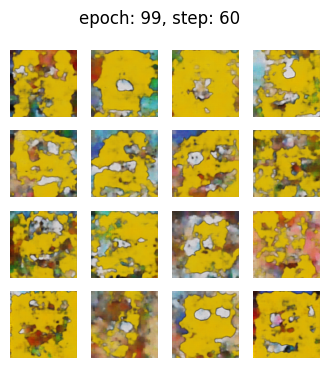

Epoch: 99 step: 60 mean loss = 169.99072
Epoch: 99 step: 61 mean loss = 169.98369


In [108]:
# Training loop. Display generated images each epoch


epochs = 100
random_vector_for_generation = tf.random.normal(shape=[16, LATENT_DIM])
generate_and_save_images(decoder, 0, 0, random_vector_for_generation)

for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))

  # Iterate over the batches of the dataset.
  for step, x_batch_train in enumerate(training_dataset):
    with tf.GradientTape() as tape:
      reconstructed = vae(x_batch_train)
      # Compute reconstruction loss
      flattened_inputs = tf.reshape(x_batch_train, shape = [-1])
      flattened_outputs = tf.reshape(reconstructed, shape = [-1])
      loss = mse_loss(flattened_inputs, flattened_outputs) * 64 * 64 * 3
      loss += sum(vae.losses)
    grads = tape.gradient(loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))

    loss_metric(loss)

    if step % 10 == 0:
      display.clear_output(wait=False)
      generate_and_save_images(decoder, epoch, step, random_vector_for_generation)
    print('Epoch: %s step: %s mean loss = %s' % (epoch, step, loss_metric.result().numpy()))


In [109]:
import tensorflow_datasets as tfds

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step


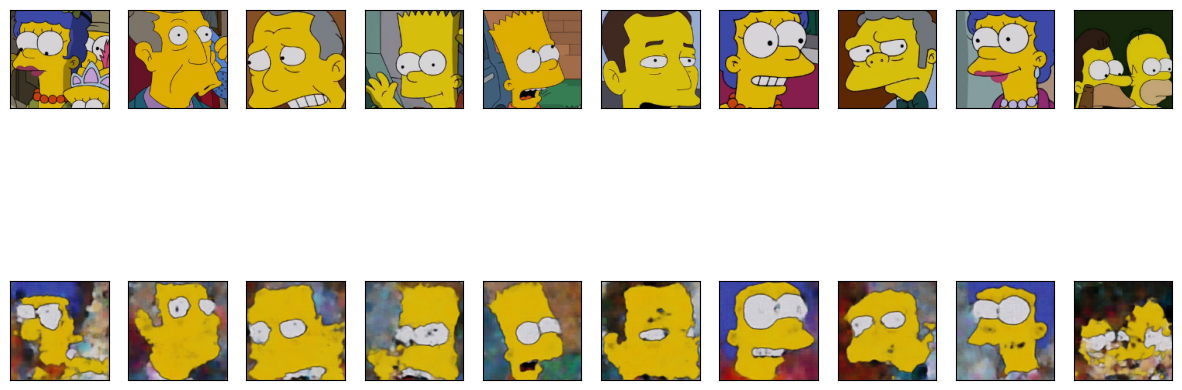

In [110]:
test_dataset = validation_dataset.take(1)
output_samples = []

for input_image in tfds.as_numpy(test_dataset):
      output_samples = input_image

idxs = np.random.choice(64, size=10)

vae_predicted = vae.predict(test_dataset)
display_results(output_samples[idxs], vae_predicted[idxs])

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step


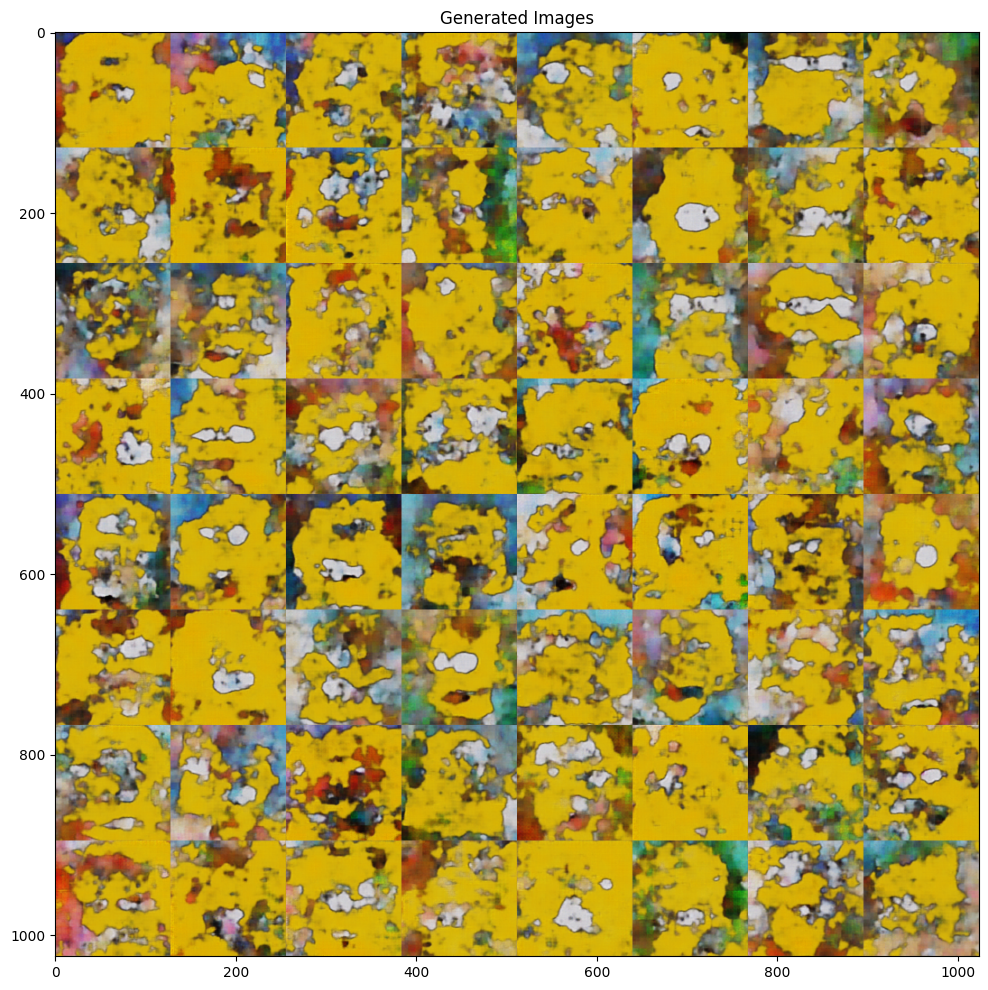

In [111]:
def plot_images(rows, cols, images, title):
    '''Displays images in a grid.'''
    grid = np.zeros(shape=(rows*128, cols*128, 3))
    for row in range(rows):
        for col in range(cols):
            grid[row*128:(row+1)*128, col*128:(col+1)*128, :] = images[row*cols + col]

    plt.figure(figsize=(12,12))
    plt.imshow(grid)
    plt.title(title)
    plt.show()

# initialize random inputs
test_vector_for_generation = tf.random.normal(shape=[128, LATENT_DIM])

# get predictions from the decoder model
predictions= decoder.predict(test_vector_for_generation)

# plot the predictions
plot_images(8,8,predictions,'Generated Images')

In [112]:
vae.save("simpson.keras")